#  Image Classification with Multilayer Perceptrons

*HFT Stuttgart, 2024 Summer Term, Michael Mommert (michael.mommert@hft-stuttgart.de)*

Multilayer Perceptrons (MLPs) represent in some sense the simplest implementation of an artificial neural network. We will build an MLP from scratch with PyTorch and train it on the task of image classification. For this purpose, we will use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

This Notebook is based on work by the amazing Dr. Marco Schreyer.

In [ ]:
%pip install numpy \
    matplotlib \
    scikit-learn \
    seaborn \
    torch \
    tqdm \
    torchvision

Note: you may need to restart the kernel to use updated packages.


In [45]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

# import sklearn classification evaluation library
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# import progress bar
from tqdm.notebook import tqdm

# set fixed random seed values
seed_value = 42 
np.random.seed(seed_value) # set Numpy seed
torch.manual_seed(seed_value) # set Pytorch seed for both CPU and GPU

Google Colab provides free GPUs for running notebooks. However, if you just execute this notebook as is, it will use your device's CPU (as if you were running the notebook on Bilder or some other cloud computing service). To run the notebook on a GPU at Colab, you have to go to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down. Running this lab on a CPU is fine, but you will find that GPU computing is faster. `cuda:0` indicates that the notebook  is using a GPU.

Enable GPU computing by setting the device flag and init a CUDA seed:

In [26]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by e.g. `Google's Colab` environment (this will result in an error message, if you do not have access to a GPU):

In [27]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Dataset Download and Data Assessment

The **Fashion-MNIST database** is an image dataset containing a total of 70,000 images of clothing and accessories. The dataset is divided into a set of **60,000 training examples** and a set of **10,000 evaluation examples**. Each example is a **28x28 grayscale image**, associated with a **label from 10 classes**. Zalando created this dataset with the intention of providing a replacement for the popular **MNIST** handwritten digits dataset. It is a useful addition as it is a bit more complex, but still very easy to use. It shares the same image size and train/test split structure as MNIST, and can therefore be used as a drop-in replacement. It requires minimal efforts on preprocessing and formatting the distinct images.

Let's download and inspect the training images of the dataset. Therefore, let's first define the directory in which we aim to store the training data:

In [28]:
data_directory = 'data/'
if not os.path.exists(data_directory): 
    os.mkdir(data_directory)
train_path = data_directory + '/train'

Now, let's download the training data accordingly:

In [29]:
# download and transform training images
fashion_mnist_train = torchvision.datasets.FashionMNIST(root=train_path, train=True, download=True)

# split data (X) from labels (y)
X_train = fashion_mnist_train.data
y_train = fashion_mnist_train.targets

Verify the number of training images downloaded:

In [30]:
# determine the number of training data images
len(X_train)

60000

Let's have a look at some of the downloaded training images:

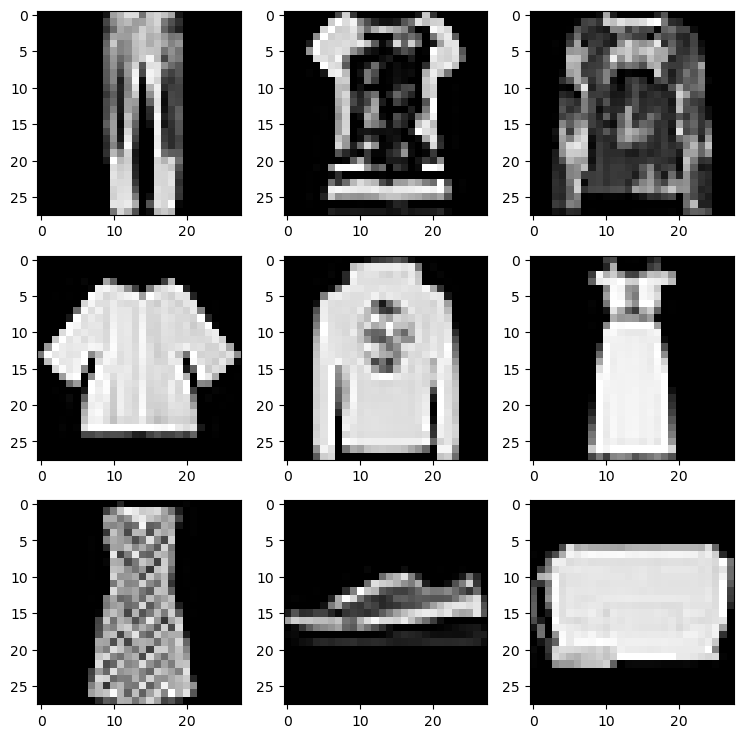

In [31]:
# select some random image ids
image_ids = np.random.randint(0, len(X_train), size=9)

# retrieve images and labels
images = X_train[image_ids]
labels = y_train[image_ids]

# create plot
f, ax = plt.subplots(3, 3, figsize=(9, 9))
ax = np.ravel(ax)

# plot each image
for i in range(len(images)):
    ax[i].imshow(images[i], cmap='gray')

Nice. Let's check what the corresponding ground truth labels are:

In [32]:
labels

tensor([1, 6, 6, 0, 2, 3, 3, 7, 8])

Ok, we know that the numerical label is 6. Each image is associated with a label from 0 to 9, and this number represents one of the fashion items. So what does 6 mean? Is 6 a bag? A pullover? The order of the classes can be found on Zalando research's [github page](https://github.com/zalandoresearch/fashion-mnist). We need to map each numerical label to its fashion item, which will be useful throughout the lab:

In [ ]:
fashion_classes = {0: 'T-shirt/top',
                   1: 'Trouser',
                   2: 'Pullover',
                   3: 'Dress',
                   4: 'Coat',
                   5: 'Sandal',
                   6: 'Shirt',
                   7: 'Sneaker',
                   8: 'Bag',
                   9: 'Ankle boot'}

So, now we can do the translation (we need `.item()` to turn the tensor into an integer) and use the labels as titles in our figure:

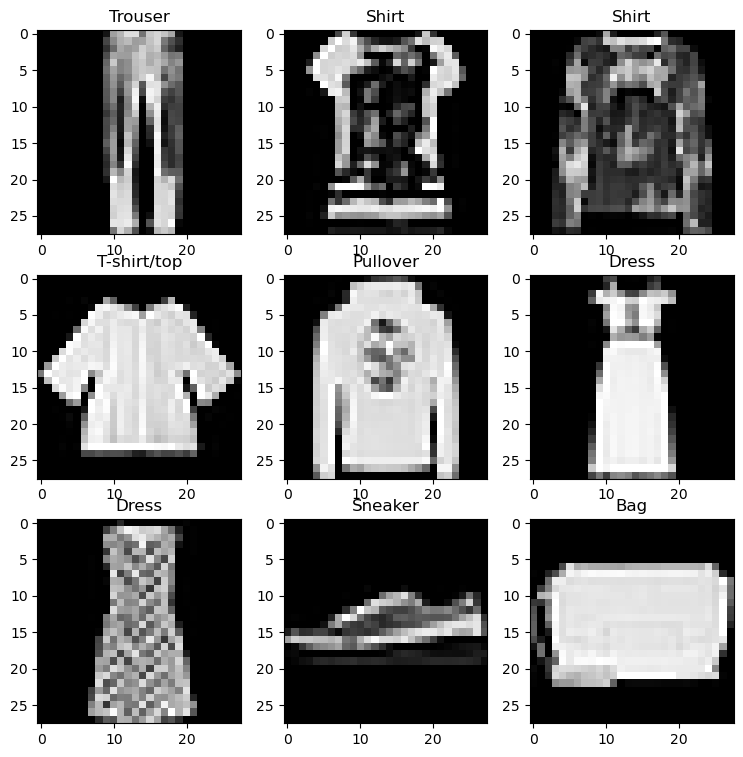

In [34]:
f, ax = plt.subplots(3, 3, figsize=(9, 9))
ax = np.ravel(ax)

for i in range(len(images)):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(fashion_classes[labels[i].item()])

Fantastic, right? Let's now download the evaluation data:

In [35]:
eval_path = data_directory + '/eval'

# download and transform training images
fashion_mnist_eval = torchvision.datasets.FashionMNIST(root=eval_path, train=False, download=True)

We will now split the evaluation dataset into equally sized chunks as our validation and test dataset:

In [36]:
X_val, X_test, y_val, y_test = train_test_split(fashion_mnist_eval.data, fashion_mnist_eval.targets, test_size=0.5, stratify=fashion_mnist_eval.targets, random_state=seed_value)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

(torch.Size([5000, 28, 28]),
 torch.Size([5000, 28, 28]),
 torch.Size([5000]),
 torch.Size([5000]))

## Neural Network Implementation

In this section we will implement the architecture of the MLP we will use to classify the 28x28 pixel FashionMNIST images.

First, let's define the input and output of the network, which will be implemented as Pytorch tensors (they work very similar to Numpy arrays, but they can be used on GPUs):
* **Input**: the input will consist of a mini-batch of FashionMNIST images. The images are greyscale images, so there is only a single band and each image has the dimensions 28x28 pixels. For a batch size `m`, the input tensor has the shape `[m, 1, 28, 28]`; this shape follows the general convention `[batch, channel, height, width]`.
* **Output**: we want to be able to classify our input images with 10 different classes available. Since each image can only have a single class label, we treat this problem as a multiclass classification problem. Therefore, our model will output a tensor of shape `[m, 10]`: for each image in the mini-batch, there will be 10 numbers, which we call logits - these are the activations of our model for the 10 different classes. The highest logit marks the class that our model predicts. Finally, we add a **Logsoftmax function** that turns the logits of one input image into a vector of numbers, the sum of which is normalized to unity, so we can use them as probabilities across the available classes.    

### Implementation of the Neural Network Architecture

Our MLP, which we define as a class named `MLP`, consists of three fully-connected or linear layers. Furthermore, our MLP should encompass the following number of neurons per layer: 100 (layer 1), 50 (layer 2) and 10 (layer 3). Meaning the first layer consists of 100 neurons, the second layer of 50 neurons and third layer of 10 neurons (the number of classes we aim to classify).

In [37]:
class MLP(nn.Module):  # our MLP class inherits functionality from the module nn.Module
    
    # define the class constructor
    def __init__(self):
        """In the constructor we define the components that we use in our architecture. """      
        super(MLP, self).__init__()  # call super class constructor
        
        self.linear1 = nn.Linear(28*28, 100)  # first linear layer (input layer): 28x28 input values to 100 output values
        self.linear2 = nn.Linear(100, 50)  # second linear layer: 100 input values to 50 output values
        self.linear3 = nn.Linear(50, 10)  # third lineary layer (output layer): 50 input values to 10 output values
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  # logsoftmax function to turn logits into values that we can use as probabilities
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function

    # define network forward pass
    def forward(self, images):
        """The forward method defines how the components defined in the constructor are put together. Note that the forward 
        pass is defined for a single sample of the mini-batch, which simplifies the setup considerably."""

        # linearize image 
        x = images.float().view(-1, 28*28)       
        x = self.relu(self.linear1(x))  # run the data through the first linear layer and ReLU        
        x = self.relu(self.linear2(x))  # run the data through the second linear layer and ReLU 
        x = self.logsoftmax(self.linear3(x))  # run the data through the third linear layer and the logsoftmax function
        
        return x

Now, that we have implemented our first neural network we are ready to instantiate the model and push it to the GPU for training:

In [ ]:
model = MLP()
model = model.to(device)

Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [ ]:
num_params = 0
for param in model.parameters():  # iterate over the trainable parameters in our architecture
    num_params += param.numel()  # collect number of parameters

print(num_params, 'parameters')

84060 parameters


## Neural Network Model Training

### Training Setup

Before we can start the training process, we have to define a few more things.

First, we have to define a **Loss Function** that will guide our model in its training process. Remember, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|C - f_\theta(X)\|$ over all training images in the FashionMNIST dataset. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. We will use the **'Negative Log Likelihood (NLL)'** loss, which is commonly used for multiclass classification problems. NLL loss is defined as follows:

$$\mathcal{L}^{NLL}_{\theta} (c_i, \hat c_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $$

for a set of $n$ images $x^{i}$, $i=1,...,n$ and their respective predicted class labels $\hat{c}^{i}$. This is summed for all the correct classes.

We instantiate the NLL loss and push it to the GPU:

In [ ]:
criterion = nn.NLLLoss().to(device)

Based on the loss value of a specific mini-batch sample, PyTorch automatically computes the gradients. Based on the gradients, and the chosen **optimizer**, Pytorch will  update the network parameters $\theta$ to facilitate the learning process for our model.

We will use **Stochastic Gradient Descent (SGD) optimization** and set the learning-rate $l = 0.0001$. Each mini-batch step the optimizer will update the model parameters $\theta$ values.

In [43]:
learning_rate = 0.0001
optimizer = optim.SGD(model.parameters(), learning_rate)

Finally, we have to define the **number of epochs** for which we would like to train the model - let's pick 10 - and the **batch size** for the training process. The batch size is actually a model hyperparameter that affects the learning of the model: higher batch size lead to a smoother learning process, since the gradients computed during backpropagation are averaged over more samples. However, since the batch size is also directly correlated to the learning rate, one typically picks a large batch size (to use the GPU efficiently) and only modifies the learning rate.

In [ ]:
num_epochs = 10  # number of training epochs
mini_batch_size = 128  # size of the mini-batches in the training process

The final ingredient for the training process are the **dataloaders**. Dataloaders are classes provided by Pytorch that provide the dataset in the required format (`[mini batch, channels, height, width]`). We need one dataloader for each of the dataset splits (the mini batch sizes for val and test equal the sizes of these datasets for quicker processing):

In [44]:
train_dataloader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=mini_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=len(X_val))
test_dataloader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=len(X_test))

### Training Process

Now we can start the model training process. The detailed training procedure for each mini-batch is performed as follows: 

>1. do a forward pass through the model, 
>2. compute the negative log likelihood loss value $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the model, and 
>4. update the parameters of the model.

For each training epoch, we will monitor the training and validation loss. While the former is used to evaluate whether the model learns anything useful, the latter is used to check for potential overfitting of the model. Furthermore, we will also monitor the accuracy on the training and validation datasets.

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [ ]:
train_epoch_losses = []  # here we will store the training losses
val_epoch_losses = []  # here we will store the validation losses
train_epoch_accs = []  # here we will store the training accuracies
val_epoch_accs = []  # here we will store the validation accuracies

# iterate over epochs
for epoch in range(num_epochs):
    
    # training process ------------------------------------
    model.train()  # set the model in training mode
    train_mini_batch_losses = []
    train_mini_batch_accs = []
    # iterate over mini batches 
    for i, (images, labels) in tqdm(enumerate(train_dataloader)):
        images = images.to(device)  # push images to GPU
        labels = labels.to(device)  # push labels to GPU

        output = model(images)  # forward pass

        model.zero_grad()  # reset gradients
        
        loss = criterion(output, labels)  # compute loss
        
        loss.backward()  # perform backprop
        optimizer.step()  # update model paramaters

        train_mini_batch_losses.append(loss.data.item())  # extract mini batch loss

        # compute accuracy
        train_mini_batch_accs.append(
            accuracy_score(labels, torch.argmax(output, dim=1).item()))
    
    # compute mean training loss and accuracy over all mini batches
    train_epoch_losses.append(np.mean(train_mini_batch_losses))
    train_epoch_accs.append(np.mean(train_mini_batch_accs))

    # evaluation process ------------------------------------
    model.eval()  # set the model in evaluation mode
    val_mini_batch_losses = []
    val_mini_batch_accs = []
    # iterate over mini batches
    with torch.no_grad():  # deactivate computational graph (saves memory) 
        for i, (images, labels) in tqdm(enumerate(val_dataloader)):
            images = images.to(device)  # push images to GPU
            labels = labels.to(device)  # push labels to GPU

            output = model(images)  # forward pass
            loss = criterion(output, labels)  # compute loss          
            val_mini_batch_losses.append(loss.data.item())  # extract mini batch loss

            # compute accuracy
            val_mini_batch_accs.append(
                accuracy_score(labels, torch.argmax(output, dim=1).item()))


    # compute mean validation loss and accuracy over all mini batches
    val_epoch_losses.append(np.mean(val_mini_batch_losses))
    val_epoch_accs.append(np.mean(val_mini_batch_accs))

    print('epoch: {}, train-loss: {:.5f}, val-loss: {:.5f} train-acc: {:.3f}, val-acc: {:.3f}'.format(
        epoch, train_epoch_losses[-1], val_epoch_losses[-1], train_epoch_accs[-1], val_epoch_accs[-1]))

Let's plot the loss and accuracy curves:

In [ ]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

# plot losses
ax[0].plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, color='red', label='train')
ax[0].plot(np.array(range(1, len(val_epoch_losses)+1)), val_epoch_losses, color='blue', label='val')

# plot accuracies
ax[1].plot(np.array(range(1, len(train_epoch_accs)+1)), train_epoch_accs, color='red', label='train')
ax[1].plot(np.array(range(1, len(val_epoch_accs)+1)), val_epoch_accs, color='blue', label='val')

# add axis labels
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")

plt.legend()

This looks good: the loss values decrease while the accuracies increase. Also, the metrics on the different dataset move in parallel, which rules out overfitting. 

We could train the network a couple more epochs until the error converges. But let's stick to 10 training epochs for now and continue with evaluating our trained model.

## Model Evaluation

We will now evaluate the trained model using the same approach but based on the test dataset this time. The goal is compute the accuracy on the test dataset to get a final evaluation of our model results.

In [ ]:
model.eval()  # set the model in evaluation mode
test_mini_batch_accs = []
with torch.no_grad():  # deactivate computational graph (saves memory) 
    # iterate over mini batches 
    for i, (images, labels) in tqdm(enumerate(test_dataloader)):
    
        images = images.to(device)  # push images to GPU
        labels = labels.to(device)  # push labels to GPU

        output = model(images)  # forward pass
        test_mini_batch_accs.append(
            accuracy_score(labels, torch.argmax(output, dim=1).item()))


# compute mean accuracy over all mini batches
test_accuracy = np.mean(test_mini_batch_accs)

print('test dataset accuracy', test_accuracy)

Ok, great. The test dataset accuracy is close to the validation accuracy, which is also a good sign.

Let's pick a sample image and predict its class:

In [ ]:
image_id = 42

# retrieve image and label data
image, label = X_test[image_id], y_test[image_id]

output = model(image)
output

Remind yourself of what we are looking at: each element of the vector may be interpreted as a probability that the image shows this class (according to our model).

Let's identify the most probable class:

In [ ]:
most_probable = torch.argmax(output, dim=1).item()
print('Most probable class: {}'.format(most_probable))
print('This class represents the following product:', fashion_classes[most_probable])
print('Actual product class:', fashion_classes[label])

XXX

This is it. We created a neural network from scratch and trained it to identify different fashion products.

**Exercise**: Compile the necessary code from above and perform a hyperparameter tuning to identify and evaluate the best-performing model.

In [ ]:
# use this cell for the exercise